## Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import * ## import necessary libraries
from fastai.utils.mem import *

In [2]:
path = untar_data(URLs.CAMVID) ## untar the cam video
path.ls() ## list out the path 

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels' # folders for labels and images 
path_img = path/'images'

## Data

In [4]:
fnames = get_image_files(path_img) # get image files from path_img 
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_05010.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_01740.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f03300.png')]

In [5]:
lbl_names = get_image_files(path_lbl) # get image files from path_lbl 
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_06480_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08340_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_05760_P.png')]

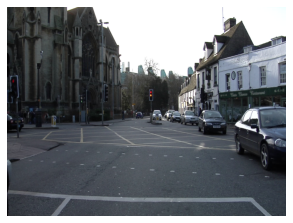

In [6]:
img_f = fnames[0]
img = open_image(img_f) ## open and display image  
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}' ## function that converts image file name to label name

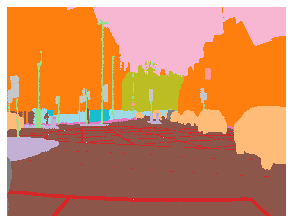

In [8]:
mask = open_mask(get_y_fn(img_f)) # use open_mask instead of open_image to return integers instead of float 
mask.show(figsize=(5,5), alpha=1) # now you can see that images are color coded 

In [9]:
src_size = np.array(mask.shape[1:]) # size is 720 by 960 
src_size,mask.data # we can see the mask data 

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17]]]))

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes ## code.txt classifies which pixel index are eg) shape[4] is a 'building' 

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [11]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))  # valid.txt are the list of file names that should be in training set 

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True) # tfm_y is to flip the image 
        .databunch(bs=bs) # use smallesr batch size
        .normalize(imagenet_stats)) #create databunch 

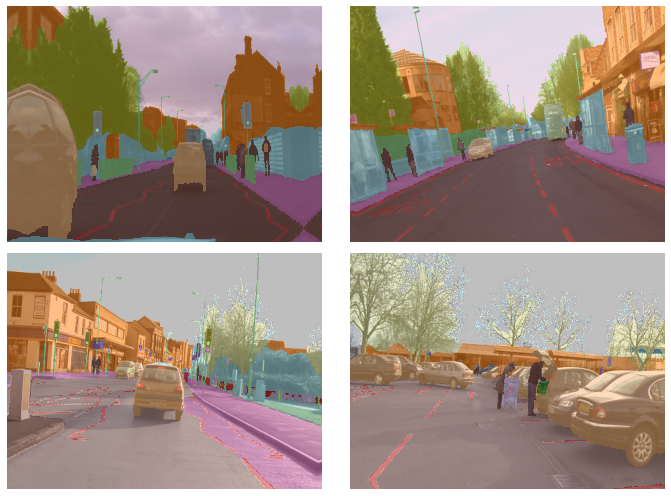

In [14]:
data.show_batch(2, figsize=(10,7)) ## display color coded image data set

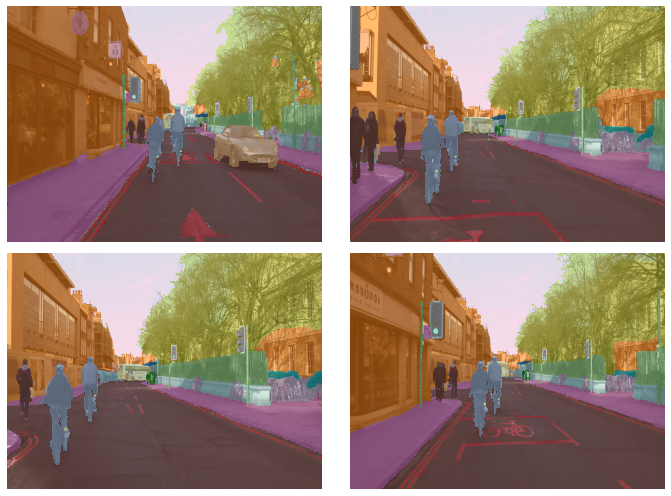

In [15]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid) ## make sure that data is in the valid type 

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):     ## function to calculate the accuracy 
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2 

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd) ## use resnet 34 model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


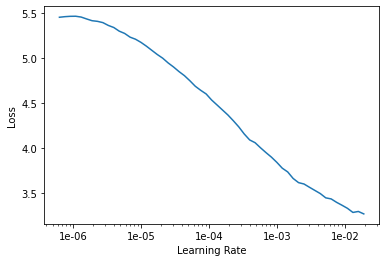

In [20]:
lr_find(learn) # find learning rate and plot it 
learn.recorder.plot()

In [0]:
lr=3e-3 # estimated learning rate with  smallestest  loss

In [22]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9) ## train the model 

epoch,train_loss,valid_loss,acc_camvid,time
0,1.003425,0.766472,0.817484,01:40
1,0.710439,0.594647,0.846871,01:39
2,0.641486,0.596829,0.858252,01:39
3,0.651349,0.580745,0.858949,01:38
4,0.600244,0.520217,0.859662,01:38
5,0.591244,0.588944,0.853175,01:37
6,0.553189,0.450426,0.882268,01:37
7,0.554952,0.417680,0.885019,01:36
8,0.496593,0.430904,0.880340,01:36
9,0.417248,0.339628,0.901882,01:36


In [0]:
learn.save('stage-1') # save the weights

In [0]:
learn.load('stage-1'); # load the weights

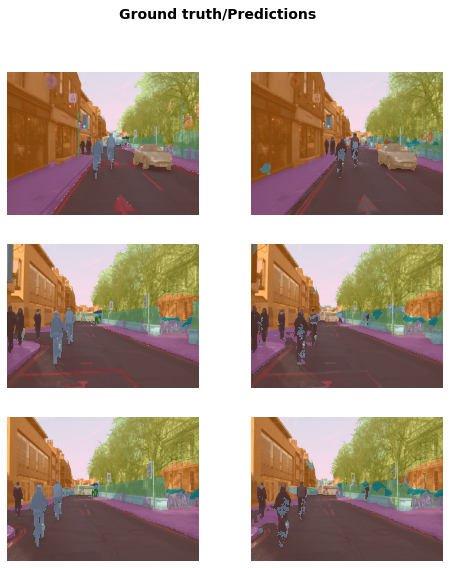

In [25]:
learn.show_results(rows=3, figsize=(8,9)) # display the results 

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4) 

In [28]:
learn.fit_one_cycle(12, lrs, pct_start=0.8) ## train with smaller learning rate  we can see that acc_camvid had decreased

epoch,train_loss,valid_loss,acc_camvid,time
0,0.359289,0.323721,0.905377,01:42
1,0.371113,0.314391,0.909186,01:42
2,0.364834,0.308802,0.913363,01:42
3,0.343666,0.307715,0.908937,01:42
4,0.328213,0.307128,0.910803,01:42
5,0.327801,0.295745,0.917507,01:42
6,0.329779,0.287283,0.918096,01:42
7,0.315578,0.285424,0.920969,01:42
8,0.302732,0.290652,0.917643,01:42
9,0.313147,0.278436,0.924127,01:42


In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [30]:
learn.destroy()

size = src_size ## original picture size , but with smaller batch size -> so it doesn't overload GPU 

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7074MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


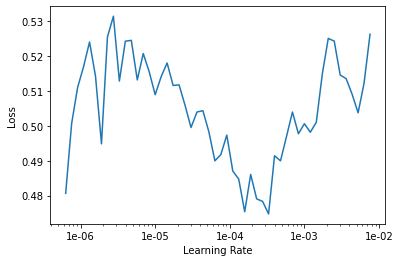

In [34]:
lr_find(learn)
learn.recorder.plot() ## find learning rate

In [0]:
lr=1e-3 ## use the learning rate with lowest loss 

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8) ## train the model 

epoch,train_loss,valid_loss,acc_camvid,time
0,0.415443,0.350914,0.902062,06:44
1,0.390512,0.315377,0.908516,06:44


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

In [0]:
learn.show_results(rows=3, figsize=(10,10))